# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import project_tests as t

import itertools
from difflib import SequenceMatcher

from collections import OrderedDict

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### Load user-item interactions file

In [3]:
df = pd.read_csv('data/user-item-interactions.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


#### Check number of unique users

In [4]:
df.email.unique().shape[0]

5149

#### There are missing emails

In [5]:
df[df.email.isnull()]

,article_id,title,email
25131,1016.0,why you should master r (even if it might even...,NaN
29758,1393.0,the nurse assignment problem,NaN
29759,20.0,working interactively with rstudio and noteboo...,NaN
29760,1174.0,breast cancer wisconsin (diagnostic) data set,NaN
29761,62.0,data visualization: the importance of excludin...,NaN
35264,224.0,"using apply, sapply, lapply in r",NaN
35276,961.0,beyond parallelize and collect,NaN
35277,268.0,sector correlations shiny app,NaN
35278,268.0,sector correlations shiny app,NaN
35279,268.0,sector correlations shiny app,NaN


#### Load contents file

In [6]:
df_content = pd.read_csv('data/articles_community.csv')
df_content.drop('Unnamed: 0', axis=1, inplace=True)
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

#### There are 5149 unique users, 5148 with valid emails and 17 null emails which were grouped as a single email.

In [7]:
total_email_entries = df.email.unique().shape[0] 
null_email_entries = df[df.email.isnull()].shape[0]
print('Total email entries: ', total_email_entries)
print('Null email entries: ', null_email_entries)
print('Valid users: ', total_email_entries - 1)

Total email entries:  5149
Null email entries:  17
Valid users:  5148


#### Remove duplicates in df

In [8]:
df2 = df.copy()

In [9]:
df.shape, df2.shape

((45993, 3), (45993, 3))

#### 50% of users interact with 3 articles. Outliers interacted with as many as 364 articles. 

In [10]:
df_ = df.groupby('email').agg({'article_id':'size'})\
.rename(columns={'article_id':'number_articles'})
df_.describe()

,number_articles
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


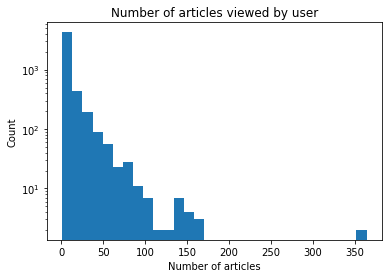

In [11]:
plt.hist(df_.number_articles, bins=30, log=True)
plt.xlabel('Number of articles')
plt.ylabel('Count')
plt.title('Number of articles viewed by user');

In [12]:
# Fill in the median and maximum number of user_article interactios below

median_val = df_.median()[0] # 50% of individuals interact with _ number of articles or fewer.
max_views_by_user = df_.max()[0] # The maximum number of user-article interactions by any 1 user is _.
print('median val: ',median_val)
print('max views by user: ', max_views_by_user)

median val:  3.0
max views by user:  364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

#### Initial shape of df_content

In [13]:
df_content.shape

(1056, 5)

#### There are article_id duplicates

In [14]:
df_content.drop_duplicates(subset=['article_id']).shape

(1051, 5)

#### All were dropped except for the first occurrence

In [15]:
df_content.drop_duplicates(subset=['article_id'], inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

#### Number of unique articles that have an interaction with a user: 714


In [16]:
unique_articles = df.article_id.unique().shape[0]

In [17]:
df.email.unique().shape

(5149,)

#### Number of unique articles in dataset: 1051

In [18]:
total_articles = df_content.article_id.unique().shape[0]
total_articles

1051

#### Number of unique users in dataset: 5148 and one null

In [19]:
unique_users = df.email.unique().shape[0]
unique_users

5149

#### Number of user-article interactions in dataset: 45993

In [20]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [21]:
user_article_interactions = df.shape[0]
print('user-article interactions: ', user_article_interactions)

user-article interactions:  45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [22]:
df2.isnull().values.any()

True

#### Top 5 most viewed articles were 1429, 1330, 1431, 1427, 1364

In [23]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [24]:
df_articles = df.groupby('article_id').size().sort_values(ascending=False).reset_index()
df_articles.head()

,article_id,0
0,1429.0,937
1,1330.0,927
2,1431.0,671
3,1427.0,643
4,1364.0,627


In [25]:
df_articles.iloc[0,0]

1429.0

In [26]:
most_viewed_article_id = str(df_articles.iloc[0,0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df_articles.iloc[0,1] # The most viewed article in the dataset was viewed how many times?
print('most_viewed_article_id: ', most_viewed_article_id)
print('max_vies: ', max_views)

most_viewed_article_id:  1429.0
max_vies:  937


In [27]:
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded


df_tmp = df.copy()

email_encoded = email_mapper()
#del df_tmp['email']
df_tmp['user_id'] = email_encoded

# show header
df_tmp.head()

,article_id,title,email,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,1
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,2
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074,3
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,4
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2,5


In [28]:
tmp_grouped = df_tmp.groupby('user_id').size()
tmp_grouped[tmp_grouped==36]

user_id
66      36
646     36
712     36
820     36
3058    36
3960    36
4130    36
4241    36
dtype: int64

In [29]:
def my_email_mapper(df):
    user_dict = {email:(i+1) for i, email in enumerate(df.email.unique())}
    df['user_id'] = df.email.apply(lambda x: user_dict[x])
    
    return df 

In [30]:
df2 = df.copy()
df2 = my_email_mapper(df2)
df2 = df2.groupby('user_id').apply(lambda x: x.sort_values('article_id')).drop_duplicates()
df2 = df2.droplevel(0)

In [31]:
df2[df2.user_id==2917]

,article_id,title,email,user_id
29759,20.0,working interactively with rstudio and noteboo...,NaN,2917
29761,62.0,data visualization: the importance of excludin...,NaN,2917
35284,162.0,an introduction to stock market data analysis ...,NaN,2917
35264,224.0,"using apply, sapply, lapply in r",NaN,2917
35278,268.0,sector correlations shiny app,NaN,2917
35281,415.0,using machine learning to predict value of hom...,NaN,2917
42749,647.0,getting started with apache mahout,NaN,2917
35282,846.0,pearson correlation aggregation on sparksql,NaN,2917
35276,961.0,beyond parallelize and collect,NaN,2917
42750,965.0,data visualization playbook: revisiting the ba...,NaN,2917


In [32]:
df2.article_id.unique().shape

(714,)

In [33]:
df_merge = df2.merge(df_content, left_on='article_id', right_on='article_id', how='left')
df_merge.head()

df_merge.article_id.unique().shape[0]

714

In [34]:
#df_merge.groupby('user_id').size().head()
df.dropna(inplace=True)

In [35]:
unique_users = df.email.unique().shape[0]
unique_users

5148

In [36]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [37]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    list_top = df.\
    groupby('article_id').\
    agg({'email':'size'}).\
    sort_values('email', ascending=False).\
    reset_index().iloc[0:n,0].values

    return df[df.article_id.isin(list_top)]['title'].values

In [38]:
print(get_top_articles(10, df))

['healthcare python streaming application demo'
 'use deep learning for image classification'
 'use deep learning for image classification' ...
 'insights from new york car accident reports'
 'visualize car data with brunel'
 'insights from new york car accident reports']


In [39]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    return df.\
        groupby('article_id').\
        agg({'email':'size'}).\
        sort_values('email', ascending=False).reset_index().iloc[0:n,0].values

In [40]:
print(get_top_article_ids(10))

[1429. 1330. 1431. 1427. 1364. 1314. 1293. 1170. 1162. 1304.]


In [41]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [42]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    
    return pd.crosstab(df['user_id'], df['article_id'])

In [43]:
user_item = create_user_item_matrix(df2)

In [44]:
df2.groupby('user_id').apply(lambda x: x.sort_values('article_id')).xs(11)

,article_id,title,email,user_id
16,12.0,timeseries data analysis of iot events by usin...,fc4e4290f2f320d80711bbe019618cc5be8815fa,11
2223,29.0,experience iot with coursera,fc4e4290f2f320d80711bbe019618cc5be8815fa,11
1474,33.0,using brunel in ipython/jupyter notebooks,fc4e4290f2f320d80711bbe019618cc5be8815fa,11
9556,43.0,deep learning with tensorflow course by big da...,fc4e4290f2f320d80711bbe019618cc5be8815fa,11
5762,74.0,the 3 kinds of context: machine learning and t...,fc4e4290f2f320d80711bbe019618cc5be8815fa,11
509,164.0,learn tensorflow and deep learning together an...,fc4e4290f2f320d80711bbe019618cc5be8815fa,11
24029,409.0,using github for project control in dsx,fc4e4290f2f320d80711bbe019618cc5be8815fa,11
846,460.0,web picks - dataminingapps,fc4e4290f2f320d80711bbe019618cc5be8815fa,11
11289,491.0,"this week in data science (may 23, 2017)",fc4e4290f2f320d80711bbe019618cc5be8815fa,11
1621,495.0,top 10 machine learning algorithms for beginners,fc4e4290f2f320d80711bbe019618cc5be8815fa,11


In [45]:
#df2[df2.email.isnull()]
df2[df2.email.isnull()]

,article_id,title,email,user_id
29759,20.0,working interactively with rstudio and noteboo...,NaN,2917
29761,62.0,data visualization: the importance of excludin...,NaN,2917
35284,162.0,an introduction to stock market data analysis ...,NaN,2917
35264,224.0,"using apply, sapply, lapply in r",NaN,2917
35278,268.0,sector correlations shiny app,NaN,2917
35281,415.0,using machine learning to predict value of hom...,NaN,2917
42749,647.0,getting started with apache mahout,NaN,2917
35282,846.0,pearson correlation aggregation on sparksql,NaN,2917
35276,961.0,beyond parallelize and collect,NaN,2917
42750,965.0,data visualization playbook: revisiting the ba...,NaN,2917


In [46]:
np.unique(user_item.values)

array([0, 1])

In [47]:
user_item.sum(axis=1)[1]

36

In [48]:
user_item.shape

(5149, 714)

In [49]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."

print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [50]:
user_id = 4

target_4 = user_item.iloc[user_id-1,:].values

In [51]:
user_id = 23

target_23 = user_item.iloc[user_id-1,:].values

In [52]:
np.dot(target_4, target_23)

16

In [53]:
df.email.unique().shape

(5148,)

In [54]:
user_item.shape

(5149, 714)

In [55]:
user_id = 3933

target_array = user_item.iloc[user_id-1,:].values
similarity = user_item.dot(target_array).sort_values(ascending=False)
similarity[1:].values
#user_item.apply(lambda x: np.dot(x,target_array), axis=1).sort_values(ascending=False)

array([35, 17, 17, ...,  0,  0,  0])

In [56]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user

    # sort by similarity

    # create list of just the ids
   
    # remove the own user's id
       
    #return most_similar_users # return a list of the users in order from most to least similar
     
    target_array = user_item.iloc[user_id-1,:].values
    return user_item.dot(target_array).sort_values(ascending=False)[1:].values

In [57]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [35 17 17 15 15 14 14 13 13 12]
The 5 most similar users to user 3933 are: [35 17 17 15 15]
The 3 most similar users to user 46 are: [40 26 26]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [58]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    
    article_ids = [float(i) for i in article_ids]
    return df.set_index('article_id').loc[article_ids, 'title'].unique().tolist()

In [59]:
article_ids=[0.0,2.0]
get_article_names(article_ids)

['detect malfunctioning iot sensors with streaming analytics',
 'this week in data science (april 18, 2017)']

In [60]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = (user_item.loc[user_id,:]).where(lambda x: x>0).dropna().sort_values(ascending=False).index.tolist()
    article_ids = [str(i) for i in article_ids]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names



In [61]:
user_id = 3

article_ids, article_names = get_user_articles(user_id)
article_ids[:5], article_names[:5]

(['1436.0', '1432.0', '788.0', '784.0', '735.0'],
 ['welcome to pixiedust',
  'visualize data with the matplotlib library',
  'quick guide to build a recommendation engine in python',
  '10 data science, machine learning and ai podcasts you must listen to',
  'making sense of the bias / variance trade-off in (deep) reinforcement learning'])

In [62]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    similar_users = set(find_similar_users(user_id))
    recs = []
    for user in similar_users:
        _, article_names = get_user_articles(user+1)
        recs.extend(article_names)

    return recs[:m] # return your recommendations for this user_id    

In [63]:
user_id=1
recs = user_user_recs(user_id)
recs

['working with ibm cloud object storage in r',
 'welcome to pixiedust',
 'working with ibm cloud object storage in python',
 'python if statements explained (python for data science basics #4)',
 'rapidly build machine learning flows with dsx',
 'shiny: a data scientist’s best friend',
 'analyze db2 warehouse on cloud data in rstudio in dsx',
 'tidyverse practice: mapping large european cities',
 'new shiny cheat sheet and video tutorial',
 'python for loops explained (python for data science basics #5)']

In [64]:
get_user_articles(20)

(['1320.0', '844.0', '232.0'],
 ['housing (2015): united states demographic measures',
  'use the cloudant-spark connector in python notebook',
  'self-service data preparation with ibm data refinery'])

In [65]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [66]:
def get_articles(user_id):
    return user_item.loc[user_id,:].where(lambda x: x>0).dropna().index.tolist()

In [84]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    df_ = user_item.dot(target_array).to_frame('similarity').reset_index()
    df_['num_interactions'] = df_.apply(lambda x: len(get_articles(x.user_id)), axis=1)

    return df_.sort_values(['similarity','num_interactions'], ascending=False).reset_index()[1:]

In [85]:
user_id = 1
df_ = get_top_sorted_users(user_id, df=df, user_item=user_item)
df_.head()

,index,user_id,similarity,num_interactions
1,3932,3933,35,35
2,22,23,17,135
3,3781,3782,17,135
4,202,203,15,96
5,4458,4459,15,96


In [275]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    df_ = get_top_sorted_users(user_id, df=df, user_item=user_item)
    target_read, _ = get_user_articles(user_id)
    rank_articles = df2.groupby('article_id').size().sort_values(ascending=False).index

    recommend = []

    for user in df_.user_id.tolist():
        user_read, _ = get_user_articles(user, user_item=user_item)
        recommend.extend([i for i in rank_articles if str(i) in user_read])

    recs = (list(OrderedDict.fromkeys(recommend)))
    rec_names = get_article_names(recs)
    
    return recs[:m], rec_names[:m]

In [276]:
user_user_recs_part2(1, m=10)

([1429.0,
  1431.0,
  1427.0,
  43.0,
  1436.0,
  1368.0,
  1170.0,
  1185.0,
  1430.0,
  1293.0],
 ['use deep learning for image classification',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'deep learning with tensorflow course by big data university',
  'welcome to pixiedust',
  'putting a human face on machine learning',
  'apache spark lab, part 1: basic concepts',
  'classify tumors with machine learning',
  'using pixiedust for fast, flexible, and easier data analysis and experimentation',
  'finding optimal locations of new store using decision optimization'])

In [251]:
tmp1 = df2.groupby('article_id').size().sort_values(ascending=False).index.values
np.where(tmp1==1183.), np.where(tmp1==1232.), np.where(tmp1==1363.)

((array([86]),), (array([484]),), (array([381]),))

In [273]:
user_id=1
df_ = get_top_sorted_users(user_id, df=df, user_item=user_item)
#[user for user in df_.user_id.tolist()]
target_read, _ = get_user_articles(user_id)
rank_articles = df2.groupby('article_id').size().sort_values(ascending=False).index

recommend = []

for user in df_.user_id.tolist():
    user_read, _ = get_user_articles(user, user_item=user_item)
    recommend.extend([i for i in rank_articles if str(i) in user_read])

#get_article_names(recommend)
print(len(recommend))
print(len(list(OrderedDict.fromkeys(recommend))))

33646
714


In [268]:
rank_articles = df2.groupby('article_id').size().sort_values(ascending=False).index


user=23
user_read, _ = get_user_articles(user, user_item=user_item)
#recommend = np.array(list(set(target_read).difference(set(user_read))))
print(recommend)
#print(np.intersect1d(np.array(rank_articles), np.array(recommend)))
#print(sorted(zip(np.array(rank_articles), np.array(recommend))))  
#    recommend.extend(set(target_read).difference(user_read))
#np.sort(recommend, order=rank_articles.values)
#rank_articles.values
#recommend
[i for i in rank_articles if str(i) in recommend]

['1363.0' '968.0' '390.0' '151.0' '525.0' '1232.0' '1406.0' '585.0'
 '268.0' '768.0' '732.0' '1400.0' '626.0' '310.0' '668.0' '346.0' '494.0'
 '329.0' '1183.0']


[151.0,
 390.0,
 1400.0,
 732.0,
 268.0,
 1183.0,
 310.0,
 525.0,
 329.0,
 494.0,
 1406.0,
 768.0,
 968.0,
 585.0,
 346.0,
 1363.0,
 1232.0,
 668.0,
 626.0]

In [232]:
for user in df_.user_id.tolist():
    user_read, _ = get_user_articles(user, user_item=user_item)
    np.intersect1d(np.array(rank_articles), np.array(user_read))
    
    recommend.extend(set(target_read).difference(user_read))


np.intersect1d(np.array(rank_articles), np.array(recommend))
#recommend
#[x for _,x in sorted(zip(Y,X))]
#df2[df2['user_id']==user_id]
#rank_articles = {article:n for n, article in enumerate(df2.groupby('article_id').size().sort_values(ascending=False).index)}

#df_.head()
#df2[df2.user_id==3933]['article_id'].apply(lambda x: x)

Float64Index([1330.0, 1429.0, 1364.0, 1314.0, 1398.0, 1431.0, 1271.0, 1427.0, 1160.0,   43.0,
              ...
              1344.0,  724.0, 1200.0, 1202.0,  984.0,  974.0, 1233.0, 1237.0, 1266.0, 1119.0], dtype='float64', name='article_id', length=714)

array(['1052.0', '109.0', '1170.0', '1183.0', '1185.0', '1232.0',
       '1293.0', '1305.0', '1363.0', '1368.0', '1391.0', '1400.0',
       '1406.0', '1427.0', '1429.0', '1430.0', '1431.0', '1436.0',
       '1439.0', '151.0', '268.0', '310.0', '329.0', '346.0', '390.0',
       '43.0', '494.0', '525.0', '585.0', '626.0', '668.0', '732.0',
       '768.0', '910.0', '968.0', '981.0'], dtype='<U32')

In [181]:
df2.groupby('article_id').size().xs(268.0)

110

In [184]:
#df2.groupby('article_id').size()
#df2[df2.article_id==268]
df2.groupby('article_id').size().xs(268.0)

rank_articles[268.0]

83

In [109]:
user_id=1
df_ = get_top_sorted_users(user_id, df=df, user_item=user_item)
df_.head()

,index,user_id,similarity,num_interactions
1,3932,3933,35,35
2,22,23,17,135
3,3781,3782,17,135
4,202,203,15,96
5,4458,4459,15,96


In [198]:
df_2 = df_.copy()
df_2['samples'] = df_2.user_id.apply(lambda x: get_articles(x))
df_3 = pd.DataFrame(df_2.apply(lambda x: pd.Series(x['samples']),axis=1).stack())
df_3.index.set_levels(df_2.user_id, level=0, inplace=True)
#df_3['similarity']=df_['similarity']
df_3.rename(columns={0:'article_id'},inplace=True)
df_3.index.names = ['user_id','index_1']
df_3['rank_article'] = df_3['article_id'].map(rank_articles)
#pd.concat([df_3], keys=df_['similarity'], names=['Firstlevel'])
#.sort_values(ascending=False)
df_3.head()
#.reset_index(level=1, drop=True)

article_id  rank_article
user_id index_1                          
3933    0              43.0             9
        1             109.0            43
        2             268.0            83
        3             310.0           136
        4             329.0           182

In [222]:
df_3.groupby(level=0).apply(lambda x: x.index)

user_id
2       MultiIndex(levels=[[3933, 23, 3782, 203, 4459,...
3       MultiIndex(levels=[[3933, 23, 3782, 203, 4459,...
4       MultiIndex(levels=[[3933, 23, 3782, 203, 4459,...
5       MultiIndex(levels=[[3933, 23, 3782, 203, 4459,...
6       MultiIndex(levels=[[3933, 23, 3782, 203, 4459,...
7       MultiIndex(levels=[[3933, 23, 3782, 203, 4459,...
8       MultiIndex(levels=[[3933, 23, 3782, 203, 4459,...
9       MultiIndex(levels=[[3933, 23, 3782, 203, 4459,...
10      MultiIndex(levels=[[3933, 23, 3782, 203, 4459,...
11      MultiIndex(levels=[[3933, 23, 3782, 203, 4459,...
12      MultiIndex(levels=[[3933, 23, 3782, 203, 4459,...
13      MultiIndex(levels=[[3933, 23, 3782, 203, 4459,...
14      MultiIndex(levels=[[3933, 23, 3782, 203, 4459,...
15      MultiIndex(levels=[[3933, 23, 3782, 203, 4459,...
16      MultiIndex(levels=[[3933, 23, 3782, 203, 4459,...
17      MultiIndex(levels=[[3933, 23, 3782, 203, 4459,...
18      MultiIndex(levels=[[3933, 23, 3782, 203, 4459,...
19    

In [185]:
rank_articles[268.0]

83

In [188]:
#df_3.loc[3933,:]
#df_3['article_id']
df_3['rank_article'] = df_3['article_id'].map(rank_articles)
df_3.head()

article_id  rank_article
user_id index_1                          
3933    0              43.0             9
        1             109.0            43
        2             268.0            83
        3             310.0           136
        4             329.0           182

## Code Bank

In [ ]:
#df_2 = df_.set_index(['user_id'])
#df_2.index.get_level_values(0)
#df_.set_index('user_id').apply(lambda x: get_articles(x.index), axis=1)
#df_.set_index('user_id').apply(lambda x: x.clip(x.name['user_id']))

#df_['article_id'] = df_.apply(lambda x: get_articles(x.user_id), axis=1)
#pd.DataFrame(df_.apply(lambda x: get_articles(x.user_id), axis=1).tolist()).stack()
df_ = user_item.dot(target_array).to_frame('similarity').reset_index()
#df_['article_list'] = df_.apply(lambda x: get_articles(x.user_id), axis=1)
#df_['article_list'] = 
df_['num_interactions'] = df_.apply(lambda x: len(get_articles(x.user_id)), axis=1)

df_.sort_values(['similarity','num_interactions'], ascending=False).reset_index()
#df_ = df_.join(df_['article_list'].apply(pd.Series)).drop('article_list', axis=1)
#df_2 = df_.set_index('user_id')
#df_.head()
#df_2.head()
#pd.melt(df_, id_vars=['user_id'], value_vars=df_.columns[1:])
#pd.melt(df_, id_vars=['user_id'])
#type(df_2)
#df_.set_index('user_id')['article_id'].apply(lambda x: pd.Series(x[0]))
#df_['article_id'].apply(lambda x: pd.Series(x[0])).stack().reset_index(level=1, drop=True).\
#to_frame('article_id').join(df_, how='right', lsuffix='_left', rsuffix='_right')

In [ ]:
#df_.merge(pd.DataFrame(df_2), left_index=True, right_index=True)
df_.join(pd.DataFrame(df_2))
#pd.DataFrame(df_.apply(lambda x: get_articles(x['user_id'])).tolist()).stack()
#pd.DataFrame(df_.apply(lambda x: get_articles(x['user_id'])))
#df_2.head()
#df_2.reset_index()
#df_.MultiIndex.join(df_2, how='left', level=0)

In [ ]:
#pd.DataFrame(df_.groupby(['user_id']).apply(lambda x: get_articles(x.user_id)).tolist()).stack()


In [ ]:
df_ = df_.join(pd.DataFrame(df_.user_id.apply(lambda x: get_articles(x)).tolist()))

In [ ]:
df_.head()

In [ ]:
df_.columns[2:]

In [ ]:
pd.melt(df_, value_vars=df_.columns[2:])

In [ ]:
user_id = 1
target_array = user_item.iloc[user_id-1,:].values
df_ = user_item.dot(target_array).sort_values(ascending=False).to_frame('similarity').reset_index()
df_user_article = df2.groupby('user_id').size().to_frame('user-interaction').reset_index()
df_.merge(df_user_article, left_on='user_id', right_on='user_id')
df_article_view = df2.groupby('article_id').size().to_frame('article-interaction').reset_index()
df_article_view.head()
#df_.merge(df_article_view, left_on='article_id', right_on='article_id')
#df_group.head()